In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = "data/pp_check"
seed_data = pd.read_csv(os.path.join(data_folder, 'pp_sample_ipu.csv'))
seed_data = seed_data.drop(columns=["serialno", "sample_geog"])
seed_data

,age,sex,relationship,persinc,nolicence,anywork
0,50-59,M,Main,$1000-1249 p.w.,Some Licence,Y
1,40-49,F,Spouse,$1-199 p.w.,Some Licence,N
2,10-19,F,Child,Zero Income,No Licence,N
3,0-9,F,Child,Zero Income,No Licence,N
4,50-59,F,Parent,$1-199 p.w.,Some Licence,N
...,...,...,...,...,...,...
75404,60-69,F,Main,$400-599 p.w.,Some Licence,Y
75405,70-79,M,Main,$300-399 p.w.,Some Licence,N
75406,70-79,F,Spouse,$300-399 p.w.,Some Licence,N
75407,70-79,F,Main,$400-599 p.w.,Some Licence,N


In [3]:
# saa_data = pd.read_csv(os.path.join(data_folder, 'SAA_PP_seed_test.csv'))
csp_seed_data = pd.read_csv(os.path.join(data_folder, 'csp_results_allz.csv'))
ipu_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_ipu.csv'))
csp_bn_data = pd.read_csv(os.path.join(data_folder, 'csp_results_BN_better_constraints.csv'))
hhsz_bn_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_bn_hhsz_constraint.csv'))

In [4]:
pp_persinc_order = [
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]

In [5]:
check = {
    "IPU": ipu_data,
    # "SAA": saa_data,
    "BN-hhsz": hhsz_bn_data,
    "CSP-seed": csp_seed_data,
    "CSP-BN": csp_bn_data,
    "VISTA": seed_data
}

In [6]:
len(seed_data[seed_data["relationship"].isin(["Main", "Spouse", "Child"])]) / len(seed_data) * 100

90.63109177949582

<Axes: title={'center': 'Relationship Frequency Comparison'}, xlabel='relationship'>

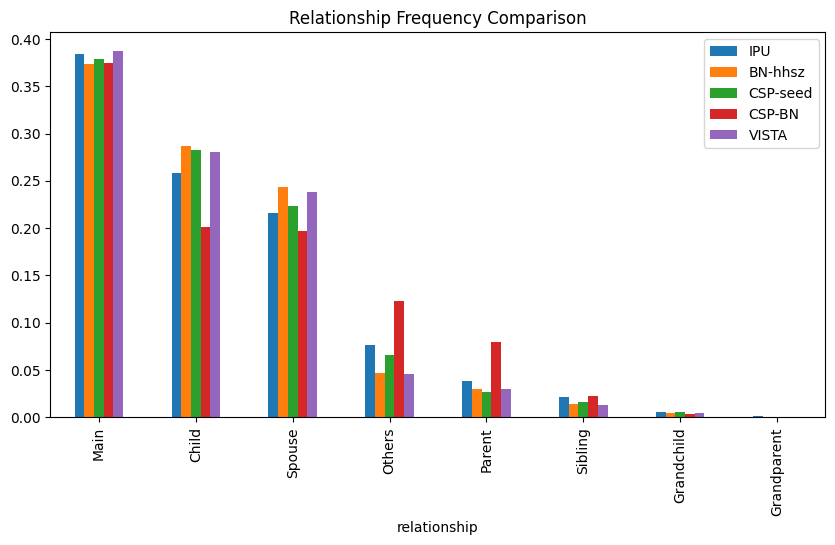

In [7]:
# compare the frequency of each relationships
def compare_freq_rela(check_data):
    hold = {}
    for name, data in check_data.items():
        processed = data["relationship"].value_counts(normalize=True)
        hold[name] = processed
    hold = pd.DataFrame(hold)
    return hold

compare_freq_rela(check).plot(kind="bar", figsize=(10, 5), title="Relationship Frequency Comparison")

In [8]:
def compare_rela(check_data, rela, attr):
    process_sub = {name: df[df["relationship"]==rela] for name, df in check_data.items()}
    if attr == "persinc":
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(pp_persinc_order) for name, df in process_sub.items()}
    elif attr == "age":
        expected_order = list(sorted(seed_data[attr].unique()))
        expected_order.remove("100+")
        expected_order.append("100+")
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(expected_order) for name, df in process_sub.items()}
    else:
        process_sub = {name: df[attr].value_counts(normalize=True).sort_index() for name, df in process_sub.items()}

    df_plot = pd.DataFrame(process_sub)
    df_plot.plot(kind="line", marker='o', figsize=(12, 6), title=f"Comparison of {rela} {attr} distribution", alpha=0.7)
    plt.xticks(ticks=range(len(df_plot.index)), labels=df_plot.index, rotation=45)

In [9]:
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt

def compare_jsd_to_vista(check_data, relationships, attr):
    jsd_results = {}

    for rela in relationships:
        # Extract the subset for the given relationship from VISTA
        vista_df = check_data["VISTA"]
        vista_sub = vista_df[vista_df["relationship"] == rela]

        # Compute VISTA distribution
        if attr == "persinc":
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
        elif attr == "age":
            expected_order = list(sorted(seed_data[attr].unique()))
            expected_order.remove("100+")
            expected_order.append("100+")
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
        else:
            all_keys = sorted(set().union(*(df[df["relationship"] == rela][attr].unique() for df in check_data.values())))
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(all_keys, fill_value=0)

        for name, df in check_data.items():
            if name == "VISTA":
                continue  # Skip VISTA itself
            df_sub = df[df["relationship"] == rela]
            if attr == "persinc":
                dist = df_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
            elif attr == "age":
                dist = df_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
            else:
                dist = df_sub[attr].value_counts(normalize=True).reindex(vista_dist.index, fill_value=0)

            jsd = jensenshannon(vista_dist, dist)
            jsd_results[(rela, name)] = jsd

    # Create DataFrame for plotting
    result_df = pd.Series(jsd_results).unstack().sort_index()
    result_df.plot(kind='bar', figsize=(10, 6), title=f"Jensen-Shannon Distance to VISTA for '{attr}' by Relationship")
    plt.ylabel("Jensen-Shannon Distance")
    plt.xlabel("Relationship")
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    result_df.loc["mean"] = result_df.mean(axis=0)
    return result_df


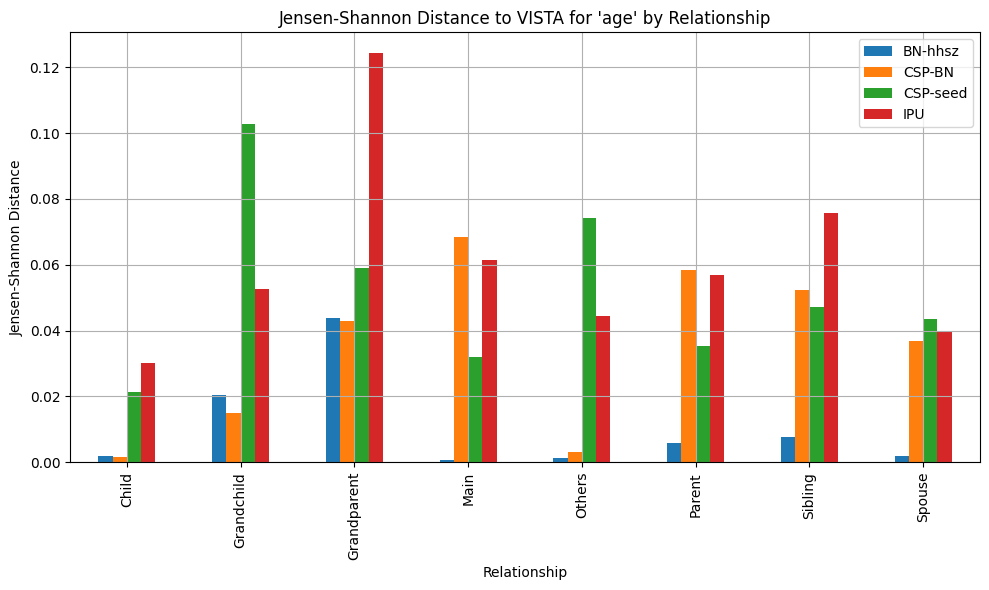

,BN-hhsz,CSP-BN,CSP-seed,IPU
Child,0.001852,0.001493,0.021253,0.030255
Grandchild,0.020350,0.015033,0.102685,0.052621
Grandparent,0.043704,0.042908,0.058875,0.124405
Main,0.000765,0.068543,0.031914,0.061502
Others,0.001425,0.003220,0.074196,0.044392
Parent,0.005737,0.058331,0.035382,0.056915
Sibling,0.007688,0.052460,0.047227,0.075620
Spouse,0.001881,0.036922,0.043581,0.039806
mean,0.010425,0.034864,0.051889,0.060690


In [10]:
compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "age")

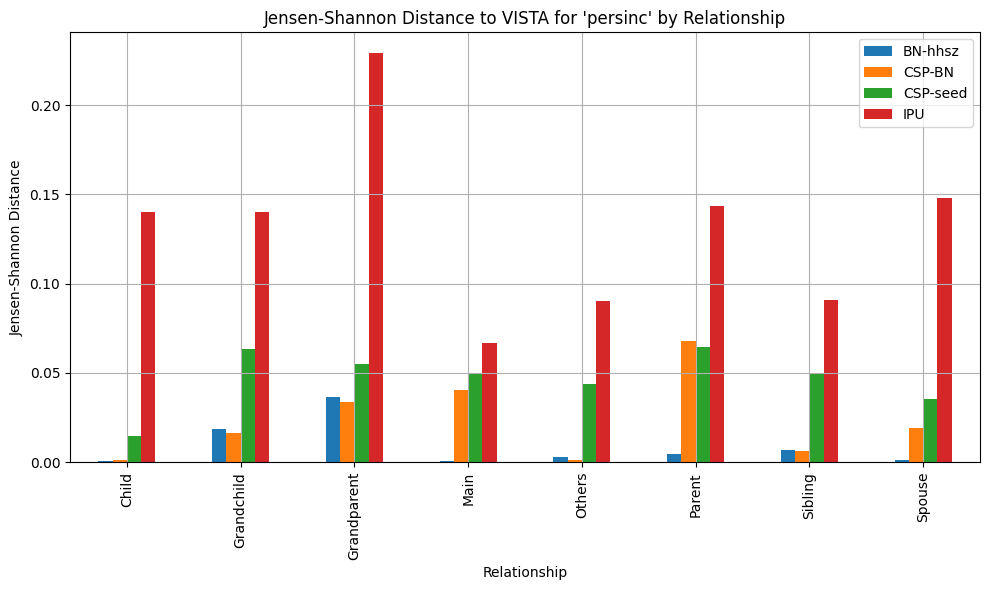

,BN-hhsz,CSP-BN,CSP-seed,IPU
Child,0.000861,0.001008,0.014822,0.140095
Grandchild,0.018828,0.016173,0.063260,0.140001
Grandparent,0.036483,0.033825,0.055097,0.229287
Main,0.000673,0.040274,0.050211,0.067032
Others,0.003064,0.001065,0.043987,0.090310
Parent,0.004850,0.067923,0.064461,0.143369
Sibling,0.006893,0.006382,0.050056,0.090709
Spouse,0.001093,0.019156,0.035602,0.147788
mean,0.009093,0.023226,0.047187,0.131074


In [11]:
compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "persinc")

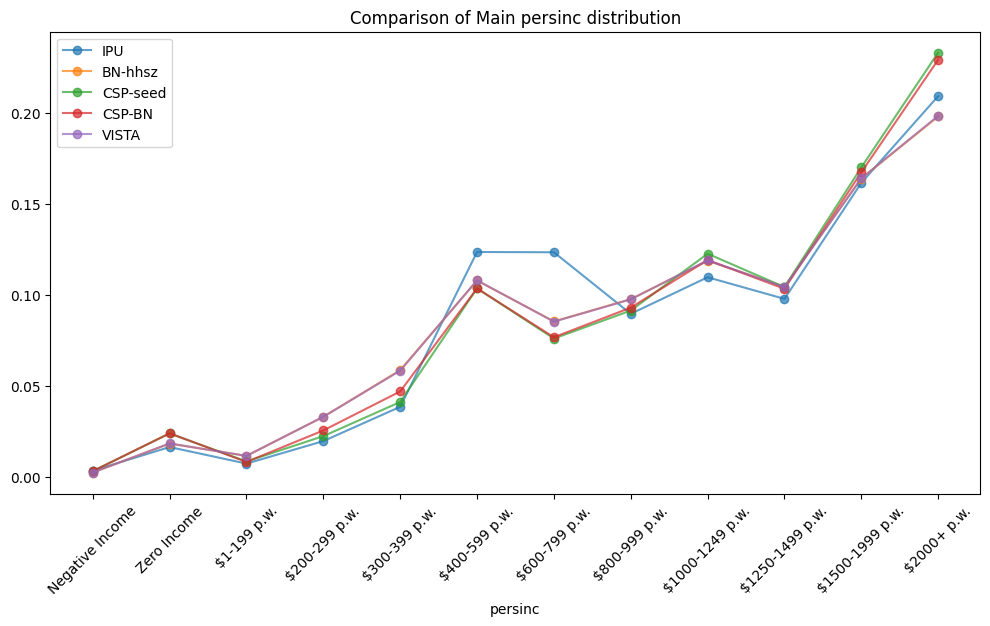

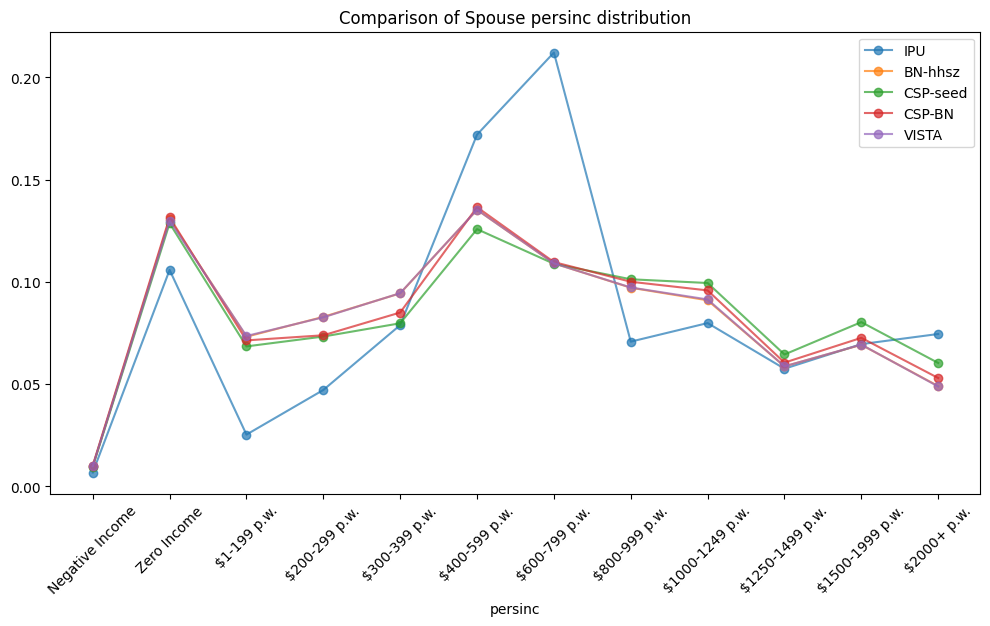

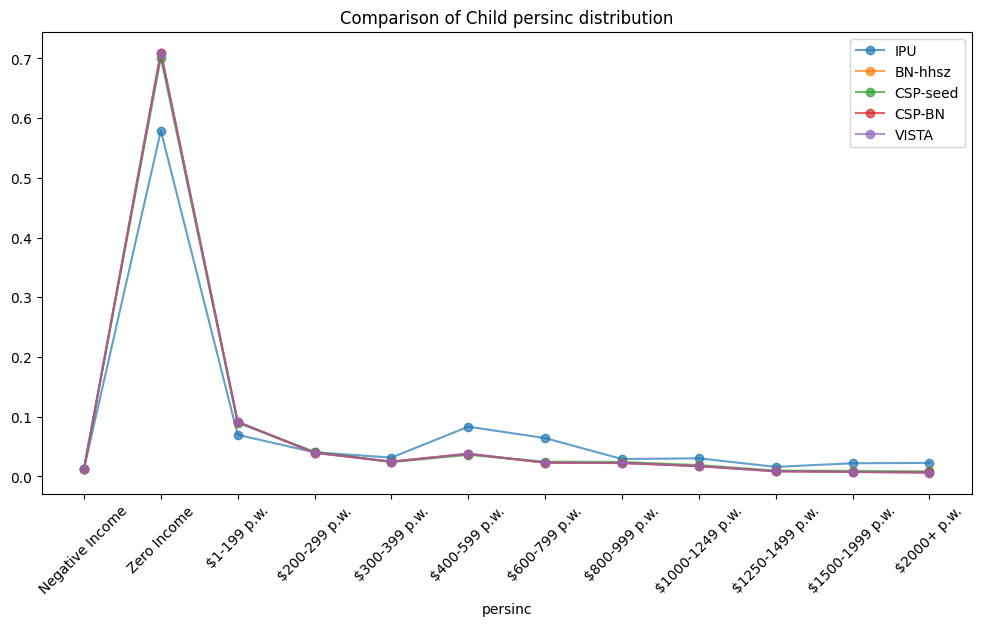

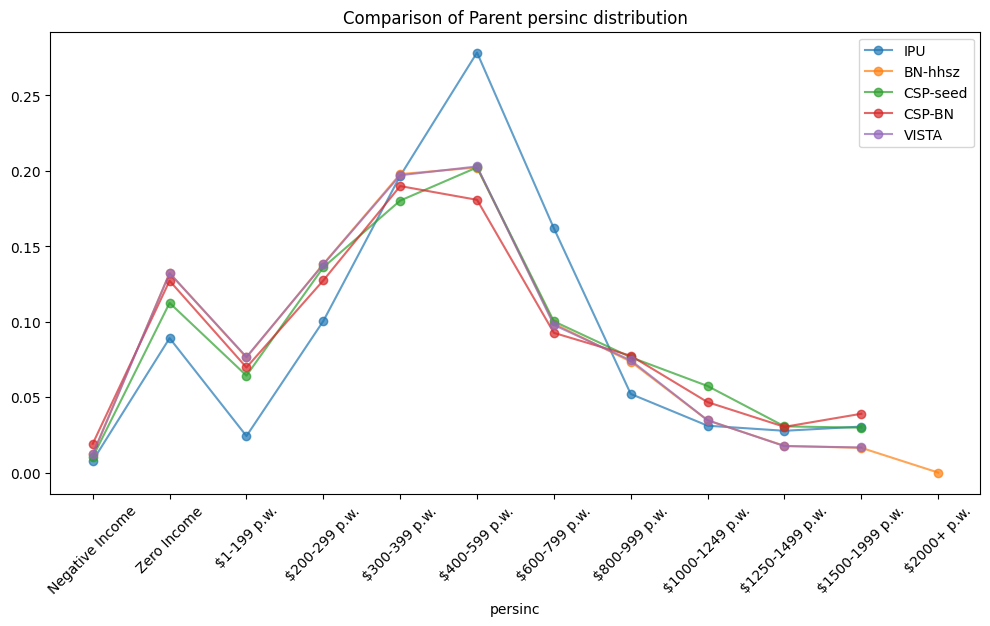

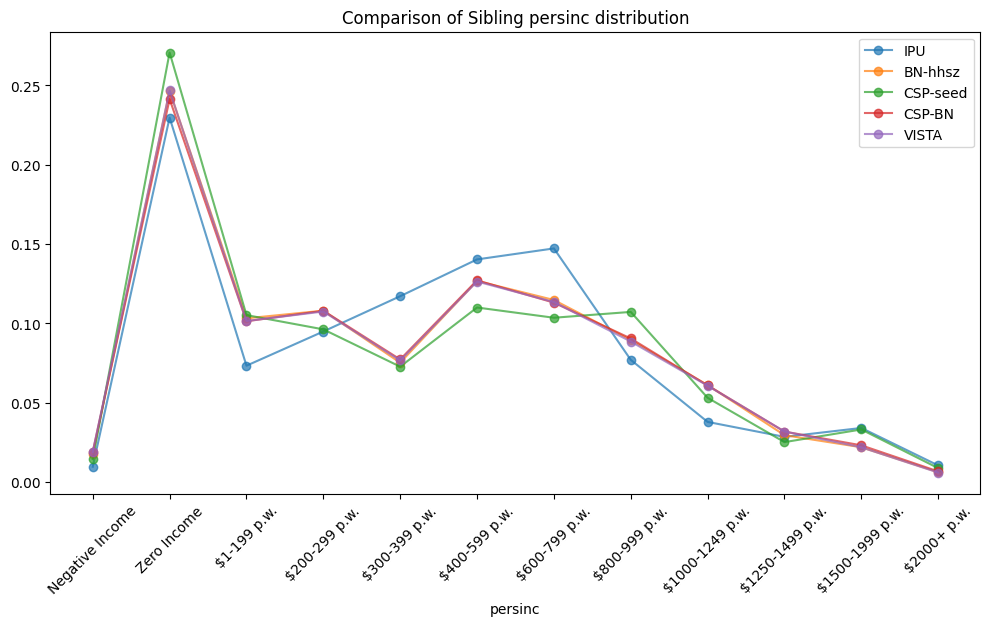

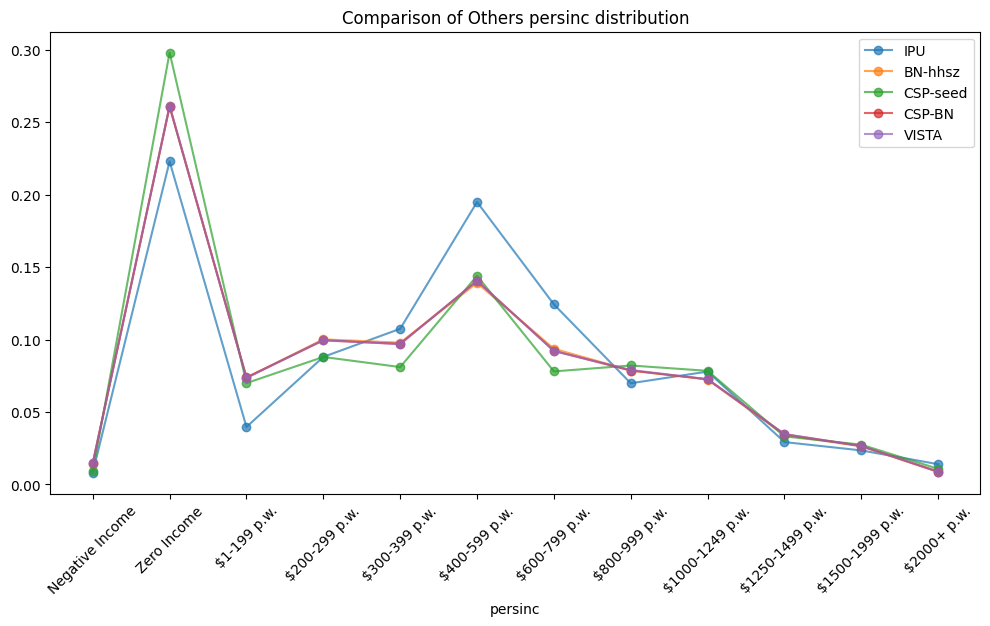

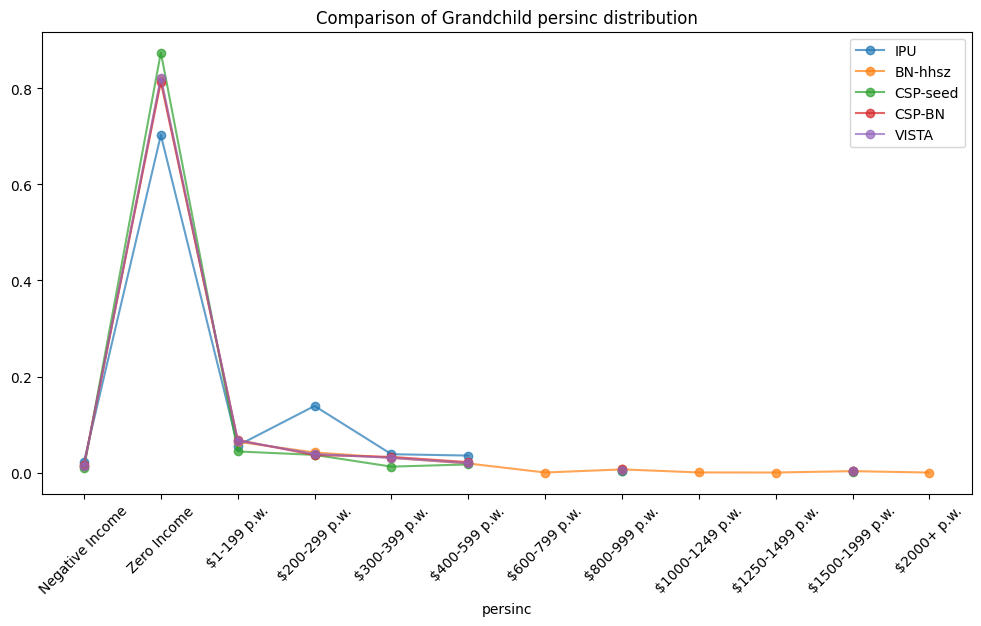

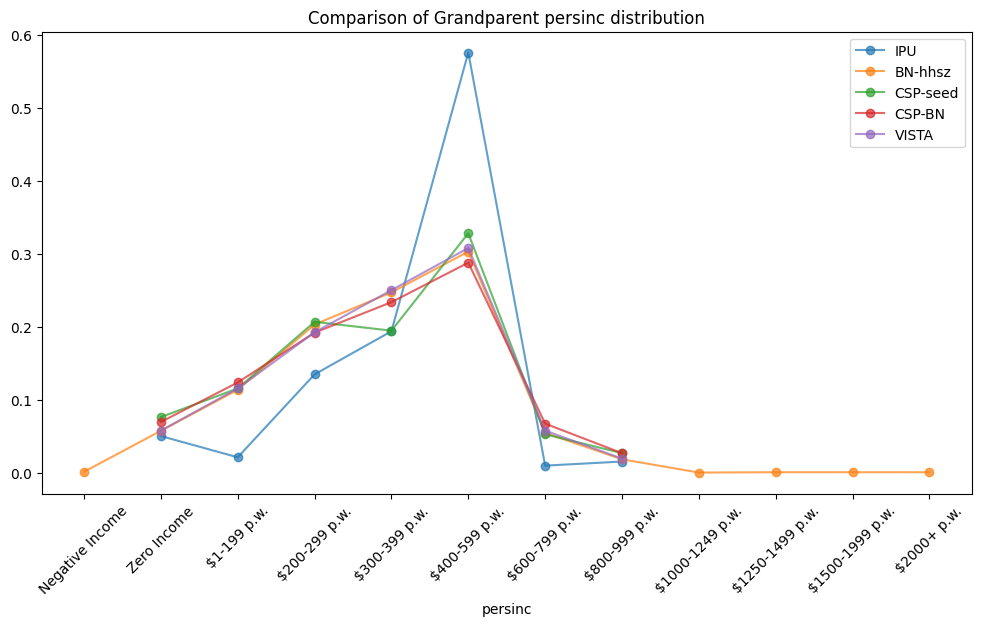

In [12]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "persinc")
    plt.show()

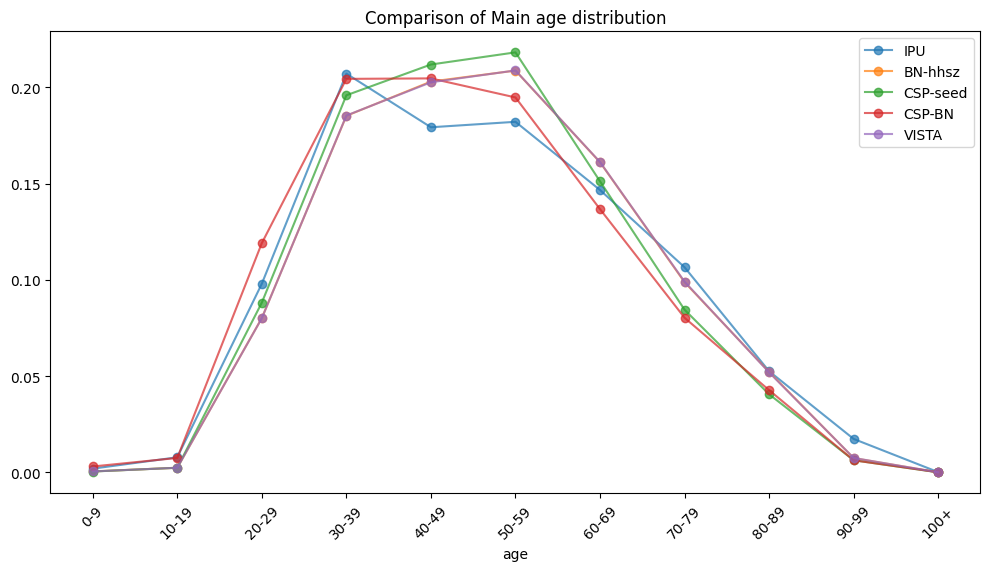

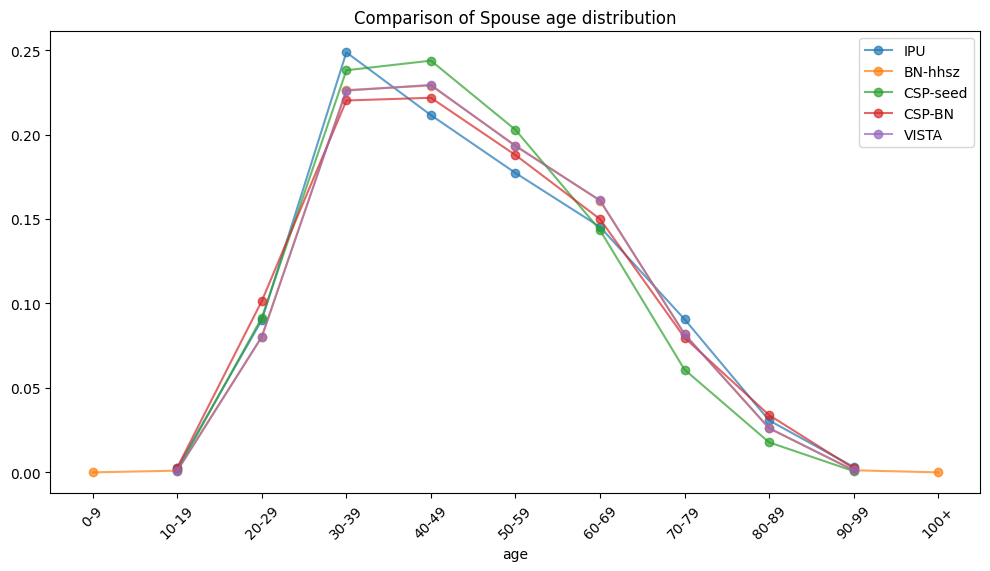

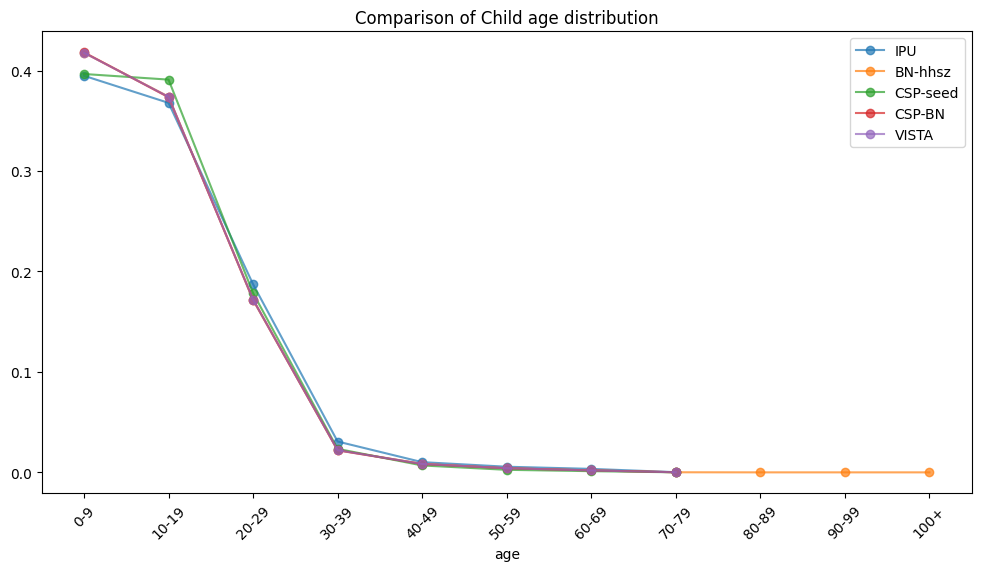

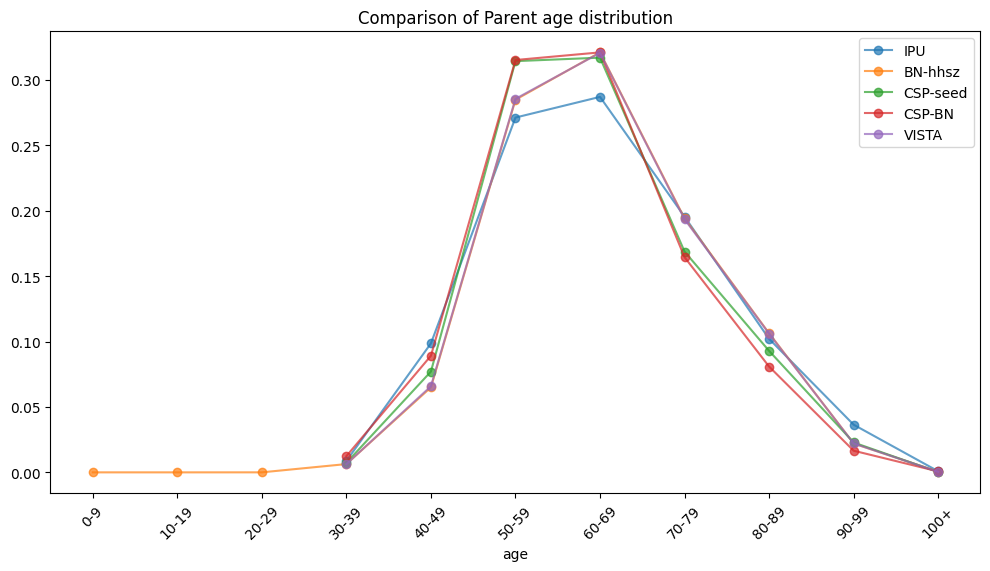

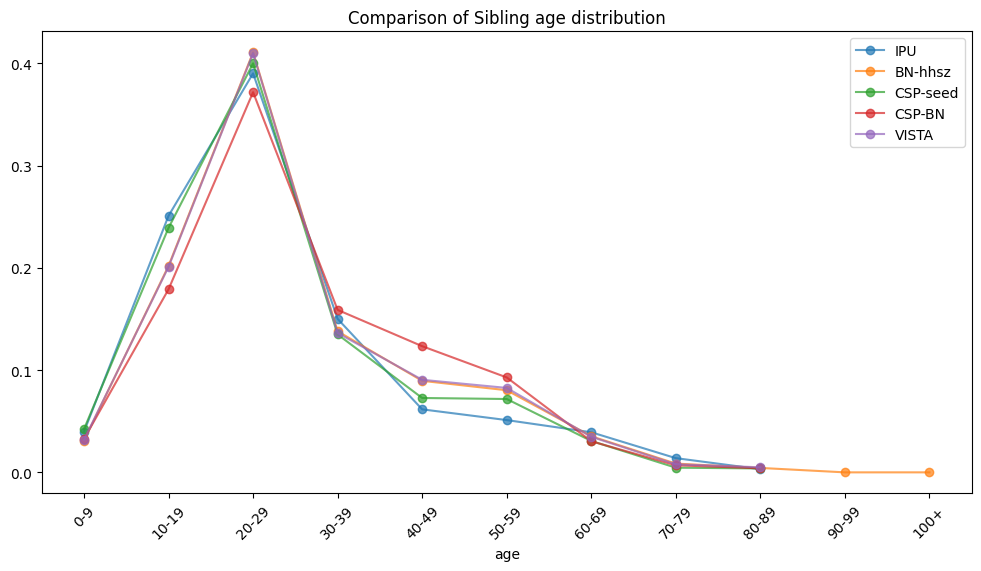

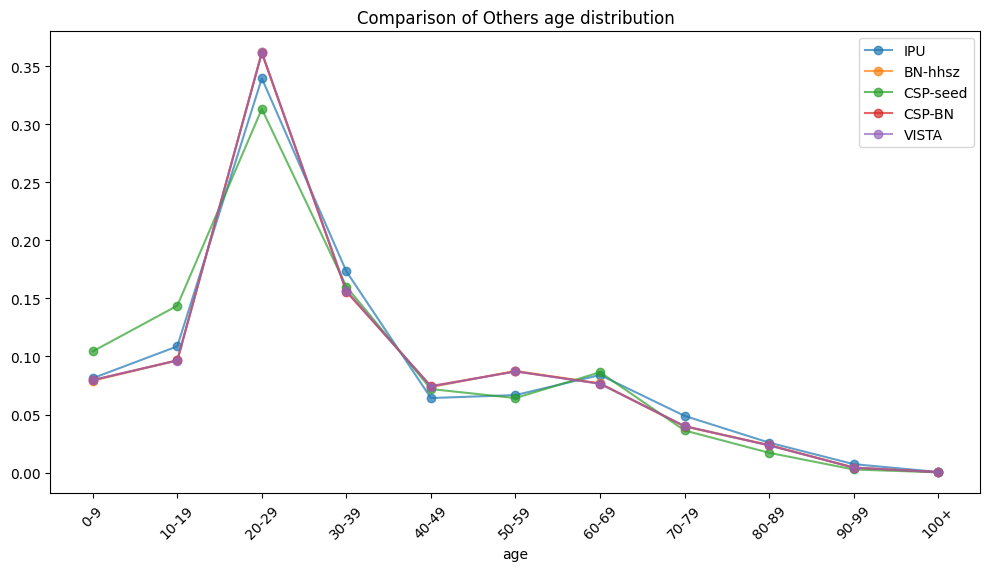

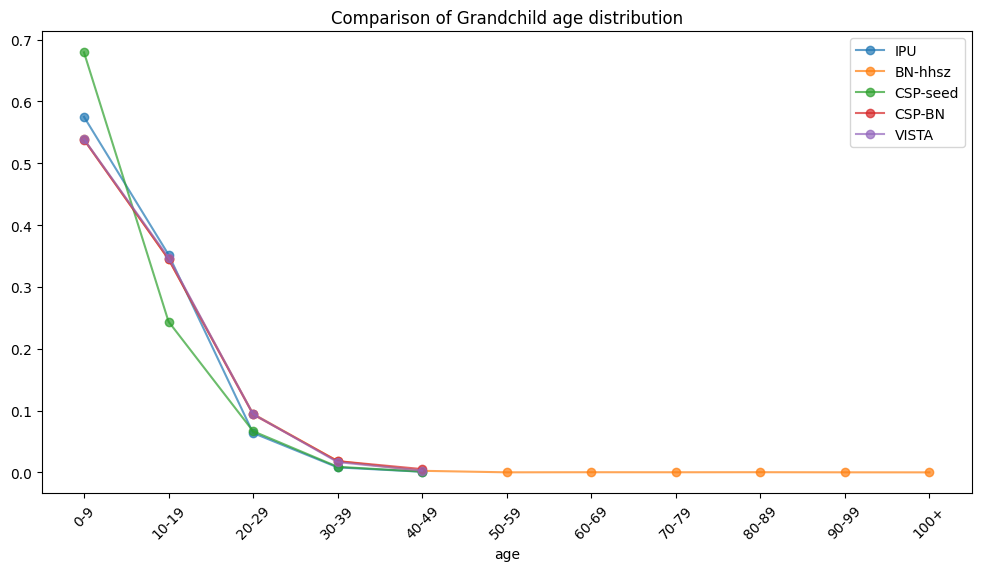

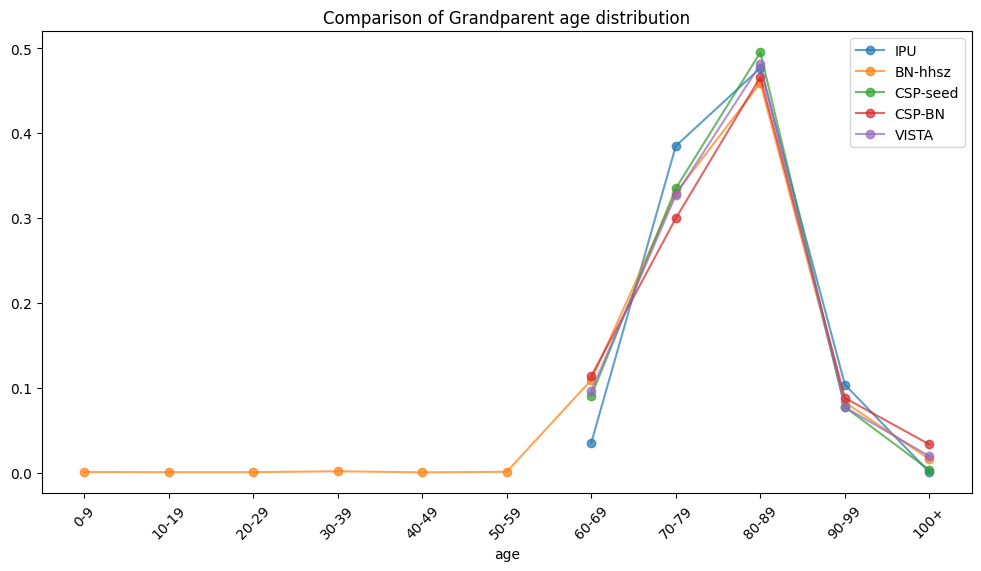

In [13]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "age")
    plt.show()